In [106]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os

In [107]:
'''
    USER INPUT
'''

DO_SAVE = False
test_name = 'full_model_load'
save_dir = os.path.join('assets', 'figs', test_name)
log_file_path = os.path.join('logs', test_name)

In [108]:
if DO_SAVE:
    os.makedirs(save_dir, exist_ok=True)

In [109]:
def parse_log_file(log_file_path):

    # Regular expressions to capture the timestamp and data from each log message type
    timestamp_regex = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})"

    idle_time_regex = re.compile(timestamp_regex + r" .*Idle time=(\d+\.?\d*)s process input time=(\d+\.?\d*)ms for layer=(\d+)")
    execute_layer_ts_regex = re.compile(timestamp_regex + r" .*Executed layer=(\d+) ([^;]*)\n")
    execute_layers_regex = re.compile(timestamp_regex + r" .*Executed to ([^;]*) layer=(\d+) in time=(\d+\.?\d*)ms")
    send_data_regex = re.compile(timestamp_regex + r" .*Sent data ACKOWLEDGED for layer=(\d+) time=(\d+\.?\d*)ms bytes=(\d+)")
    received_layer_regex = re.compile(timestamp_regex + r" .*Received layer=(\d+): receive time=(\d+\.?\d*)ms, deserialize time=(\d+\.?\d*)ms bytes=(\d+)")
    total_runtime_regex = re.compile(timestamp_regex + r" .*Total runtime=(\d+\.?\d*)s")

    # Initialize empty lists for storing the data
    idle_time_data = []
    execute_layer_ts_data = []
    execute_layers_data = []
    send_data_data = []
    received_layer_data = []

    # Read the log file and extract relevant data
    with open(log_file_path, 'r') as file:
        for line in file:
            # Check for idle time messages
            idle_time_match = idle_time_regex.search(line)
            if idle_time_match:
                idle_time_data.append({
                    'timestamp': idle_time_match.group(1),
                    'idle_time': float(idle_time_match.group(2)),
                    'process_input': float(idle_time_match.group(3)),
                    'layer': int(idle_time_match.group(4))
                })
                continue
            
            # Check for executed layer messages
            execute_layer_ts_match = execute_layer_ts_regex.search(line)
            if execute_layer_ts_match:
                execute_layer_ts_data.append({
                    'timestamp': execute_layer_ts_match.group(1),
                    'layer': int(execute_layer_ts_match.group(2)),
                    'layer_name': str(execute_layer_ts_match.group(3))
                })
                continue

            # Check for executed layer messages
            execute_layers_match = execute_layers_regex.search(line)
            if execute_layers_match:
                execute_layers_data.append({
                    'timestamp': execute_layers_match.group(1),
                    'layer_name': str(execute_layers_match.group(2)),
                    'layer': int(execute_layers_match.group(3)),
                    'execute_time': float(execute_layers_match.group(4))
                })
                continue

            # Check for sent data ACKOWLEDGED messages
            send_data_match = send_data_regex.search(line)
            if send_data_match:
                send_data_data.append({
                    'timestamp': send_data_match.group(1),
                    'layer': int(send_data_match.group(2)),
                    'send_time': float(send_data_match.group(3)),
                    'bytes': int(send_data_match.group(4))
                })
                continue

            # Check for received layer messages
            received_layer_match = received_layer_regex.search(line)
            if received_layer_match:
                received_layer_data.append({
                    'timestamp': received_layer_match.group(1),
                    'layer': int(received_layer_match.group(2)),
                    'receive_time': float(received_layer_match.group(3)),
                    'deserialize_time': float(received_layer_match.group(4)),
                    'bytes': int(received_layer_match.group(5))
                })
            
            total_runtime_match = total_runtime_regex.search(line)
            if total_runtime_match:
                total_runtime = float(total_runtime_match.group(2))


    # Convert the lists into pandas DataFrames
    idle_time_df = pd.DataFrame(idle_time_data)
    execute_layer_ts_df = pd.DataFrame(execute_layer_ts_data)
    execute_layers_df = pd.DataFrame(execute_layers_data)
    send_data_df = pd.DataFrame(send_data_data)
    received_layer_df = pd.DataFrame(received_layer_data)

    # Save DataFrames to CSV (optional)
    '''
    idle_time_df.to_csv('idle_time.csv', index=False)
    idle_time_df.to_csv('execute_layers.csv', index=False)
    send_data_df.to_csv('send_data.csv', index=False)
    received_layer_df.to_csv('received_layer.csv', index=False)
    '''

    # Print DataFrames to verify
    '''
    print("Idle Time DataFrame:")
    print(idle_time_df)
    print("\nExecute Layers DataFrame:")
    print(execute_layers_df)
    print("\nSend Data DataFrame:")
    print(send_data_df)
    print("\nReceived Layer DataFrame:")
    print(received_layer_df)
    '''

    return idle_time_df, execute_layer_ts_df, execute_layers_df, send_data_df, received_layer_df, total_runtime


In [110]:
#execute_layer_ts_df

In [111]:
def parse_debug_log_file(log_file_path):
    ''' 
        Parses extra outputs from split manager when the debug flag is enabled.
        To get these extra outputs, a second run is required.
        Extra outputs are: FLOPS, num_parameters
        It is assumed that if the debug flag is enabled the computation will be slowed and delay results will be adversely effected 
        THEREFORE, a second run is required. 
    '''
    # Regular expressions to capture the timestamp and data from each log message type
    timestamp_regex = r"(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})"

    #2024-09-21 18:15:00,763 - source.core.split_manager - DEBUG - FLOPS for conv1 layer=1 FLOPS=589824.0 parameters=576.0
    flops_regex = re.compile(timestamp_regex + r" .*FLOPS for ([^;]*) layer=(\d+) FLOPS=(\d+\.?\d*) parameters=(\d+\.?\d*)")

    # Initialize empty lists for storing the data
    flops_data = []

    # Read the log file and extract relevant data
    with open(log_file_path, 'r') as file:
        for line in file:
            # Check for idle time messages
            flops_match = flops_regex.search(line)
            if flops_match:
                flops_data.append({
                    'timestamp': flops_match.group(1),
                    'layer_name': str(flops_match.group(2)),
                    'layer': int(flops_match.group(3)), 
                    'FLOPS': float(flops_match.group(4)),
                    'parameters': float(flops_match.group(5))
                })
                continue

    # Convert the lists into pandas DataFrames
    flops_df = pd.DataFrame(flops_data)

    # Save DataFrames to CSV (optional)
    '''
    idle_time_df.to_csv('flops_df.csv', index=False)
    '''

    # Print DataFrames to verify
    #print("FLOPS DataFrame:")
    #print(flops_df)

    return flops_df


In [112]:
'''
    Get data for each log file
'''

total_runtime = []
for i in range(4):
    #print(f'\n\n Network Node {i}')
    node_log_file_path= os.path.join(log_file_path,f'node{i}_resnet18.log')
    node_log_debug_path = os.path.join(log_file_path,f'node{i}_resnet18_debug.log')
    idle_time_df_tmp, execute_layer_ts_df_tmp, execute_layers_df_tmp, send_data_df_tmp, received_layer_df_tmp, total_runtime_tmp = parse_log_file(node_log_file_path)
    flops_df_tmp = parse_debug_log_file(node_log_debug_path)

    total_runtime.append(total_runtime_tmp)

    idle_time_df_tmp['node'] = i
    execute_layer_ts_df_tmp['node'] = i
    execute_layers_df_tmp['node'] = i
    send_data_df_tmp['node'] = i
    received_layer_df_tmp['node'] = i
    flops_df_tmp['node'] = i

    if i ==0:
        idle_time_df = idle_time_df_tmp
        execute_layer_ts_df = execute_layer_ts_df_tmp
        execute_layers_df = execute_layers_df_tmp
        send_data_df = send_data_df_tmp
        received_layer_df = received_layer_df_tmp
        flops_df = flops_df_tmp
    else:
        idle_time_df = pd.concat([idle_time_df, idle_time_df_tmp])
        execute_layer_ts_df = pd.concat([execute_layer_ts_df, execute_layer_ts_df_tmp])
        execute_layers_df = pd.concat([execute_layers_df_tmp, execute_layers_df])
        send_data_df = pd.concat([send_data_df_tmp, send_data_df])
        received_layer_df = pd.concat([received_layer_df_tmp, received_layer_df])
        flops_df = pd.concat([flops_df, flops_df_tmp])

# convert timestamp strings to datetime
time_format_str = '%Y-%m-%d %H:%M:%S,%f'
idle_time_df['timestamp'] = pd.to_datetime(idle_time_df['timestamp'], format=time_format_str)
execute_layer_ts_df['timestamp'] = pd.to_datetime(execute_layer_ts_df['timestamp'], format=time_format_str)
execute_layers_df['timestamp'] = pd.to_datetime(execute_layers_df['timestamp'], format=time_format_str)
send_data_df['timestamp'] = pd.to_datetime(send_data_df['timestamp'],format=time_format_str)
received_layer_df['timestamp'] = pd.to_datetime(received_layer_df['timestamp'], format=time_format_str)
flops_df['timestamp'] = pd.to_datetime(flops_df['timestamp'], format=time_format_str)

# zero to 1st entry across all messages TODO: use starting model debug message as reference 
start_time = min(pd.concat([idle_time_df['timestamp'], execute_layer_ts_df['timestamp'],  execute_layers_df['timestamp'], send_data_df['timestamp'], received_layer_df['timestamp']]))
idle_time_df['timestamp'] = (idle_time_df['timestamp'] -start_time).dt.total_seconds()
execute_layer_ts_df['timestamp'] = (execute_layer_ts_df['timestamp'] - start_time).dt.total_seconds()
execute_layers_df['timestamp'] = (execute_layers_df['timestamp']-start_time).dt.total_seconds()
send_data_df['timestamp'] = (send_data_df['timestamp']-start_time).dt.total_seconds()
received_layer_df['timestamp'] = (received_layer_df['timestamp']-start_time).dt.total_seconds()



In [113]:
idle_time_df_tmp, execute_layer_ts_df_tmp, execute_layers_df_tmp, send_data_df_tmp, received_layer_df_tmp, total_runtime_tmp = parse_log_file(node_log_file_path)


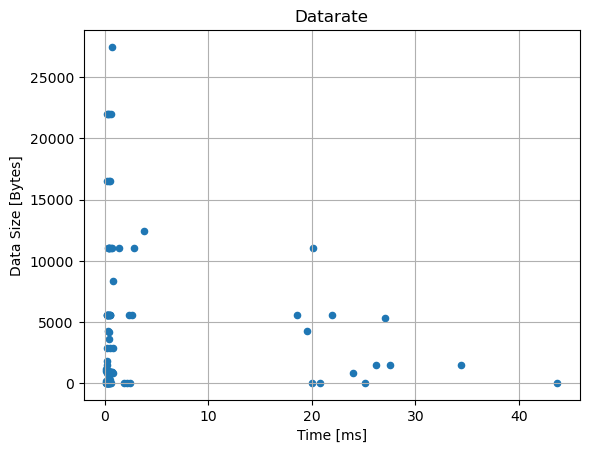

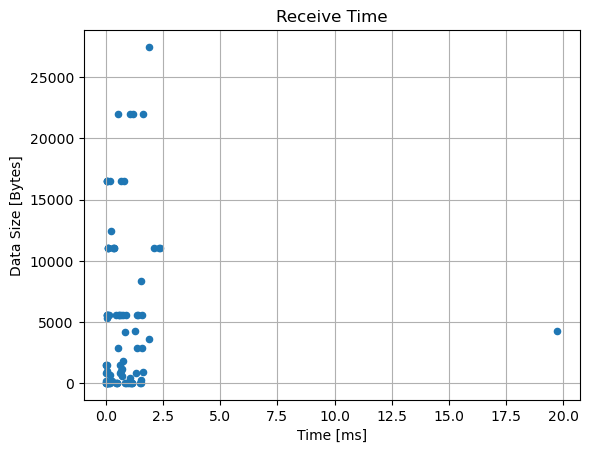

In [114]:
'''
    Make scatter plots for TX and RX
'''

ax_send = send_data_df.plot.scatter(x='send_time', y='bytes')
ax_send.set_xlabel('Time [ms]')
ax_send.set_ylabel('Data Size [Bytes]')
ax_send.set_title('Datarate')
ax_send.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_send.jpg'))

# TODO: fix the measurment of time in debugger logging
ax_receive = received_layer_df.plot.scatter(x='receive_time', y='bytes')
ax_receive.set_xlabel('Time [ms]')
ax_receive.set_ylabel('Data Size [Bytes]')
ax_receive.set_title('Receive Time')
ax_receive.grid()

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'datarate_receive.jpg'))




In [127]:
'''
    Breakdown of total time spent in different states
'''
for i in range(4):
    total_idle_time = sum(idle_time_df['idle_time'][idle_time_df['node'] == i])*1e3 # ms 
    total_exec_time = sum(execute_layers_df['execute_time'][execute_layers_df['node'] == i]) # ms
    total_tx_time = sum(send_data_df['send_time'][send_data_df['node'] == i]) # ms
    total_rx_time = sum(received_layer_df['receive_time'][received_layer_df['node'] == i] + received_layer_df['deserialize_time'][received_layer_df['node'] == i] )  # ms

    percent_idle = total_idle_time/total_runtime[i]*100/1e3
    percent_exec_time = total_exec_time/total_runtime[i]*100/1e3
    percent_tx_time = total_tx_time/total_idle_time*100 # overlap in idle time and tx time
    percent_rx_time = total_rx_time/total_idle_time*100

    data = {
            'States': ["IDLE", "EXECUTING", "TX", "RX"], 
            'Time [ms]':[total_idle_time, total_exec_time, total_tx_time, total_rx_time],
            'Percent [%]':[percent_idle, percent_exec_time, percent_tx_time, percent_rx_time], 
            }
    df = pd.DataFrame(data)
    print(f'Node {i}')
    print(f'Run time {total_runtime[i]}s')
    print(df)
    print()


Node 0
Run time 10.527124400003231s
      States  Time [ms]  Percent [%]
0       IDLE  4959.7223    47.113743
1  EXECUTING   114.3756     1.086485
2         TX   120.4808     2.429184
3         RX    46.4211     0.935962

Node 1
Run time 3.951223799987929s
      States  Time [ms]  Percent [%]
0       IDLE    71.2269     1.802654
1  EXECUTING   144.0704     3.646222
2         TX    94.6328   132.861040
3         RX    19.5775    27.486104

Node 2
Run time 3.910746499997913s
      States  Time [ms]  Percent [%]
0       IDLE    76.4720     1.955432
1  EXECUTING   110.3711     2.822251
2         TX   102.0245   133.414191
3         RX    18.1222    23.697824

Node 3
Run time 3.912561999997706s
      States  Time [ms]  Percent [%]
0       IDLE    43.3997     1.109240
1  EXECUTING   113.6101     2.903727
2         TX    55.5134   127.911944
3         RX    16.7410    38.573999



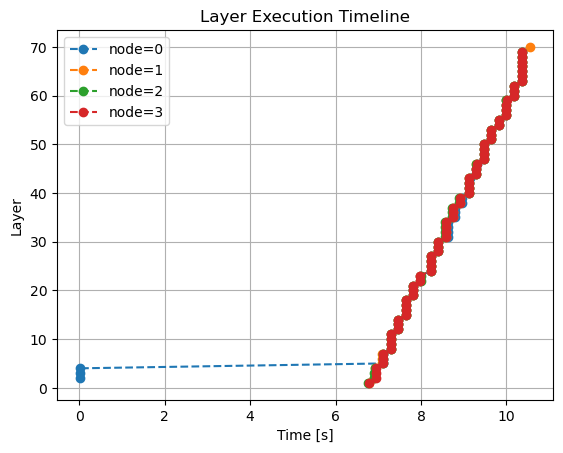

In [120]:
'''
    Look at layer execution times
'''

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):
    plt.plot(execute_layer_ts_df[execute_layer_ts_df['node'] == i]['timestamp'] ,execute_layer_ts_df[execute_layer_ts_df['node'] == i]['layer'], '--o')
    legend_strs += [f'node={i}']
plt.title('Layer Execution Timeline')
plt.xlabel('Time [s]')
plt.ylabel('Layer')
plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 10, step=1))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'layer_execution_time.jpg'))



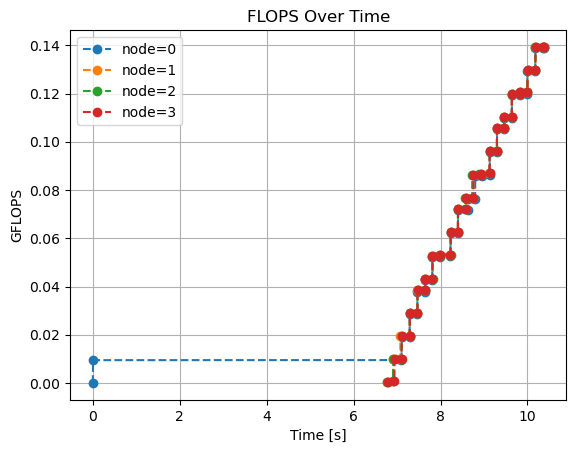

In [117]:
merged_layer_df = pd.merge(execute_layer_ts_df, flops_df, on=['layer_name', 'node', 'layer'], how='right')
merged_layer_df.sort_values(by=['timestamp_x'])

plt.figure()
plt.grid()
legend_strs = []
for i in range(4):

    tmp_merged_layer_df = merged_layer_df[merged_layer_df['node'] == i]
    cum_bytes = np.cumsum(tmp_merged_layer_df['FLOPS'].to_numpy())
    plt.plot(tmp_merged_layer_df['timestamp_x'] ,cum_bytes/1e9, '--o')
    legend_strs += [f'node={i}']
plt.title('FLOPS Over Time')
plt.xlabel('Time [s]')
plt.ylabel('GFLOPS')
_ = plt.legend(legend_strs)
#_ = plt.xticks(np.arange(0, 250, step=20))

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'FLOPS.jpg'))


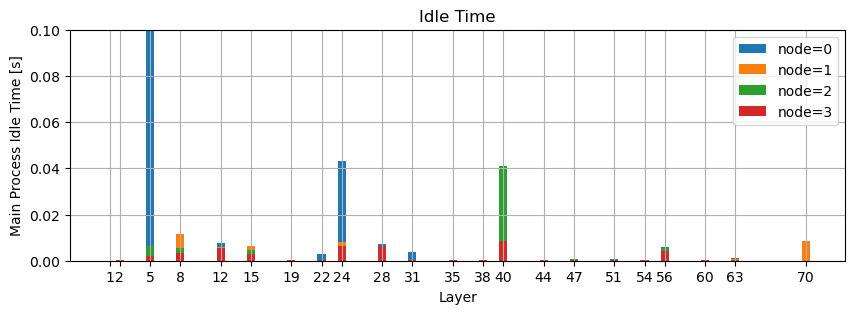

In [118]:
'''
    Look at idling durations
    - idle time includes time spent receiving
    - idle time does not include time spent sending 
    - idle time does not include time spent doing split layer computation 

    # TODO: put bars next to one another 
'''

plt.figure(figsize=(10,3))
plt.grid()
legend_strs = []
for i in range(4):
    plt.bar(idle_time_df[idle_time_df['node'] == i]['layer'] ,idle_time_df[idle_time_df['node'] == i]['idle_time'])
    legend_strs += [f'node={i}']
plt.title('Idle Time')
plt.xlabel('Layer')
plt.ylabel('Main Process Idle Time [s]')
plt.legend(legend_strs)
_ = plt.xticks(np.unique(idle_time_df['layer']))
plt.ylim(0, 0.1)

if DO_SAVE:
    plt.savefig(os.path.join(save_dir, 'idle_time.jpg'))
